In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.validation  import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection import train_test_split
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score
import csv
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

ratings = pd.read_csv(r"../input/ratings.csv")


R_dataframe = ratings.pivot_table('rating', 'userId', 'movieId', fill_value=0)
R_matrix = R_dataframe.astype('int')
movie_ratings_count = np.sum(R_matrix!=0, axis=0)
user_ratings_count = np.sum(R_matrix!=0, axis=1)

R_dataframe_var = ratings.pivot_table('rating', 'userId', 'movieId')
movie_rating_var = np.var(R_dataframe_var,axis=0)
movie_var_list = list(movie_rating_var)

reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5))
data = Dataset.load_from_file(r"../input/ratings.csv", reader=reader)
movie_ID = list(R_dataframe)



In [3]:
#question 30 attempt

import pandas as pd
import os
import numpy as np
import pandas as pd
import random
from surprise import AlgoBase
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate


# naive collaborative filter
class NaiveCollaborativeFilter(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        # Compute rating means of each user
        
        self.trainset = trainset
        self.the_means = {}
        for key in self.trainset.ur:
            urs = self.trainset.ur[key]
            mean = np.mean([r for (_, r) in urs])
            self.the_means[key] = mean

        return self

    def estimate(self, u, i):
        if self.the_means.__contains__(u):
            return self.the_means[u]
        else:
            return 0


# calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# read csv file
file_path = os.path.expanduser(r"../input/ratings.csv")
df = pd.read_csv(file_path)
del df['timestamp']

# shuffle data
df = df.sample(frac=1).reset_index(drop=True)

# 10 fold cross validation
def cross_validation(dataset):
    testlen = int(len(df) / 10)
    total_rmse = 0
    print(dataset + ':')
    for i in range(10):
        # split data into 10 pieces
        sp = int(len(df) / 10 * i)
        df1 = df[0:sp]
        df2 = df[sp:sp+testlen]
        df3 = df[sp+testlen:]

        traindf = pd.concat([df1,df3],ignore_index=True)
        reader1 = Reader(rating_scale=(0, 5))
        trainset = Dataset.load_from_df(traindf[['userId', 'movieId', 'rating']], reader1)

        alg = NaiveCollaborativeFilter()
        alg.fit(trainset.build_full_trainset())

        if dataset == "Popular Movies Dataset":
            df2['size'] = df2.groupby(['movieId']).movieId.transform(np.size)
            df2 = df2[df2['size'] > 2]

        if dataset == "Unpopular Movies Dataset":
            df2['size'] = df2.groupby(['movieId']).movieId.transform(np.size)
            df2 = df2[df2['size'] <= 2]

        if dataset == "High Variance Movies Dataset":
            df2['size'] = df2.groupby(['movieId']).movieId.transform(np.size)
            df2 = df2[df2['size'] >= 5]
            df2['var'] = df2['rating'].groupby(df2['movieId']).transform(lambda arr:np.mean((arr - arr.mean()) ** 2))
            df2 = df2[df2['var'] >= 2]
    
        reader2 = Reader(rating_scale=(0, 5))
        testset = Dataset.load_from_df(df2[['userId', 'movieId', 'rating']], reader2)
        testset = [(u, i, r) for (u, i, r) in testset.build_full_trainset().all_ratings()]

        prediction = alg.test(testset)
    
        real = []
        est = []

        # remove impossible estimation
        for j in range(len(prediction)):
            if prediction[j][3] > 0:
                real.append(prediction[j][2])
                est.append(prediction[j][3])
    
        cur_rmse = rmse(np.array(real), np.array(est))
        total_rmse += cur_rmse
        print(str(i) + 'th rmse: ' + str(cur_rmse))

    final_rmse = total_rmse / 10
    print('final_rmse: ' + str(final_rmse))
    print('')


# Q30
cross_validation("MovieLens Dataset")

# Q31
cross_validation("Popular Movies Dataset")

# Q32
cross_validation("Unpopular Movies Dataset")

# Q33
cross_validation("High Variance Movies Dataset")

MovieLens Dataset:
0th rmse: 1.1879758303548014
1th rmse: 1.1962466349906986
2th rmse: 1.153032190442849
3th rmse: 1.1986816269938978
4th rmse: 1.1546204290113453
5th rmse: 1.153164855224169
6th rmse: 1.220270469888425
7th rmse: 1.1783960267093658
8th rmse: 1.167399779277214
9th rmse: 1.146537962630726
final_rmse: 1.1756325805523493

Popular Movies Dataset:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0th rmse: 1.117947896877098
1th rmse: 1.1440601560990173
2th rmse: 1.137132473183301
3th rmse: 1.113595561783876
4th rmse: 1.1192970700664153
5th rmse: 1.095962850924737
6th rmse: 1.112936929969771
7th rmse: 1.1108734345931264
8th rmse: 1.1154324852441524
9th rmse: 1.1324146317224157
final_rmse: 1.119965349046391

Unpopular Movies Dataset:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0th rmse: 1.2480814083877516
1th rmse: 1.2405335926151337
2th rmse: 1.232227220762554
3th rmse: 1.2377538114532047
4th rmse: 1.2263223996158892
5th rmse: 1.2639669766285593
6th rmse: 1.188687194738004
7th rmse: 1.2688959368166486
8th rmse: 1.236114341862097
9th rmse: 1.2350107053400403
final_rmse: 1.2377593588219882

High Variance Movies Dataset:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0th rmse: 1.871569135538451
1th rmse: 1.6681484811469693
2th rmse: 1.73404492628325
3th rmse: 1.6179129344090113
4th rmse: 1.6838340383643313
5th rmse: 1.6154989867016472
6th rmse: 1.7800545351876735
7th rmse: 1.871649882469789
8th rmse: 1.7337928359933072
9th rmse: 1.6299450901855737
final_rmse: 1.7206450846280004



Computing the pearson similarity matrix...
Done computing similarity matrix.
knn AUC: 0.7797339346902201
nmf AUC: 0.7690380787716332
svd AUC: 0.7933130028129546


<function matplotlib.pyplot.show(*args, **kw)>

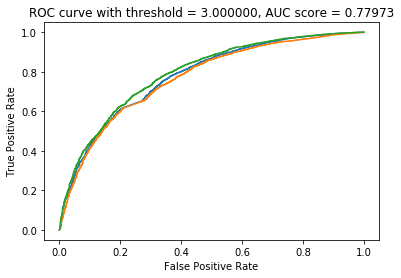

In [8]:
#question 34 some combo of


threshold = 3

compare_fprs = []
compare_tprs = []
compare_AUCs = []

trainset, testset = train_test_split(data, test_size=0.1)

#knn
knn = KNNWithMeans(k=24, sim_options={'name': 'pearson'})
knn.fit(trainset)
knn_pred = knn.test(testset)

    
real_y = []
est_y = []
for i in range(len(knn_pred)):
    est_y.append(knn_pred[i].est)
    if testset[i][2] >= threshold: 
        real_y.append(1.0)
    else:
        real_y.append(0.0)
            
fpr, tpr, thresholds = roc_curve(real_y, est_y)
AUC = roc_auc_score(real_y, est_y)
print("knn AUC: " + str(AUC))
plt.plot(fpr,tpr)
plt.title('ROC curve with threshold = %f, AUC score = %.5f' %(threshold, AUC))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

compare_fprs.append(fpr)
compare_tprs.append(tpr)
compare_AUCs.append(AUC)

nmf = NMF(n_factors=18, biased=False)
nmf.fit(trainset)
nmf_pred = nmf.test(testset)

real_y = []
est_y = []
for i in range(len(nmf_pred)):
    est_y.append(nmf_pred[i].est)
    if testset[i][2] >= threshold: #ratings threshold
        real_y.append(1.0)
    else:
        real_y.append(0.0)
        
fpr, tpr, thresholds = roc_curve(real_y, est_y)
AUC = roc_auc_score(real_y, est_y)
compare_fprs.append(fpr)
compare_tprs.append(tpr)
compare_AUCs.append(AUC)


print("nmf AUC: " + str(AUC))
plt.plot(fpr,tpr)

from surprise.prediction_algorithms.matrix_factorization import SVD


svd_biased = SVD(n_factors=28, biased=True)
svd_biased.fit(trainset)
svd_biased_pred = svd_biased.test(testset)

real_y = []
est_y = []
for i in range(len(svd_biased_pred)):
    est_y.append(svd_biased_pred[i].est)
    if testset[i][2] >= threshold: #ratings threshold
        real_y.append(1.0)
    else:
        real_y.append(0.0)

fpr, tpr, thresholds = roc_curve(real_y, est_y)
AUC = roc_auc_score(real_y, est_y)
compare_fprs.append(fpr)
compare_tprs.append(tpr)
compare_AUCs.append(AUC)

print("svd AUC: " + str(AUC))
plt.plot(fpr,tpr)
plt.show

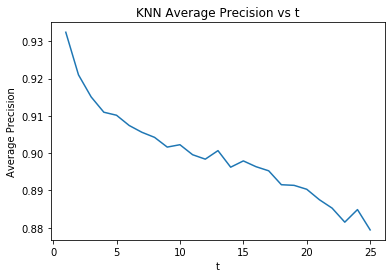

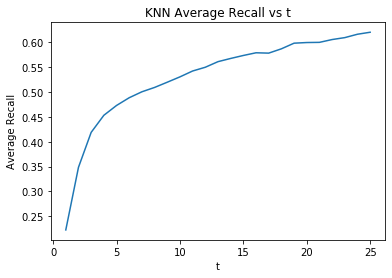

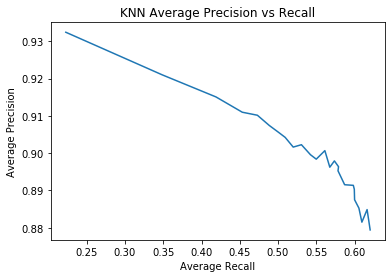

In [17]:
#question 35 explain precision and recall in report

#queestion 36

#knn 24
#nmf 18
#svd 28
from collections import defaultdict

kf = KFold(n_splits=10)

def testset_trim(testset, t):
    count = {}
    likes = {}
    
    for (u, i, r) in testset:
        if u not in count:
            count[u] = 0
        count[u] += 1
        if u not in likes:
            likes[u] = 0
        if r >= 3:
            likes[u] += 1
            
    res = []
    for (u, i, r) in testset:
        if count[u] >= t and likes[u] > 0:
            res.append((u, i, r))
    
    return res

def precision_recall(predictions, t, threshold=3):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = {}
    recalls = {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of recommended items
        n_rec_k = t
        
        # Number of relevant and recommended items in top t
        n_rel_and_rec_k = 0
        for i in range(t):
            if user_ratings[i][1] >= threshold:
                n_rel_and_rec_k += 1
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Precision
        precisions[uid] = n_rel_and_rec_k / n_rec_k

        # Recall
        recalls[uid] = n_rel_and_rec_k / n_rel

    return precisions, recalls

ts = [i for i in range(1, 25 + 1)]

knn_precision = []
knn_recall = []

for t in ts:
    temp_prec = []
    temp_recall = []

    for trainset, testset in kf.split(data):
        knn = KNNWithMeans(k=24, sim_options={'name': 'pearson'})
        knn.fit(trainset)
        trimmed_testset = testset_trim(testset, t)
        pred = knn.test(trimmed_testset)
    
        precisions, recalls = precision_recall(pred, t)
        fold_mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        fold_mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
            
        temp_prec.append(fold_mean_prec)
        temp_recall.append(fold_mean_recall)
    
    t_mean_prec = sum(prec for prec in temp_prec) / len(temp_prec)
    t_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    knn_precision.append(t_mean_prec)
    knn_recall.append(t_mean_recall)
    
    
plt.plot(ts, knn_precision)
plt.title("KNN Average Precision vs t")
plt.xlabel('t')
plt.ylabel('Average Precision')
plt.show()

plt.plot(ts, knn_recall)
plt.title("KNN Average Recall vs t")
plt.xlabel('t')
plt.ylabel('Average Recall')
plt.show()

plt.plot(knn_recall, knn_precision)
plt.title("KNN Average Precision vs Recall")
plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.show()

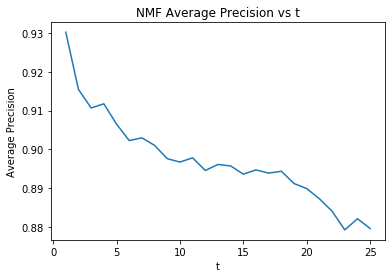

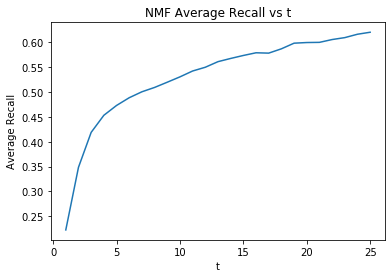

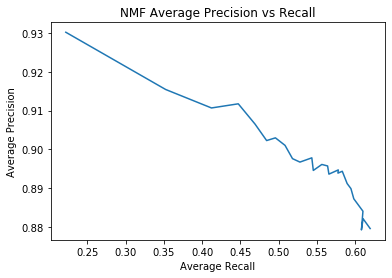

In [20]:
#question 37


nmf_precision = []
nmf_recall = []
kf = KFold(n_splits=10)

for t in ts:
    temp_prec = []
    temp_recall = []

    for trainset, testset in kf.split(data):
        nmf = NMF(n_factors=18, biased=False)
        nmf.fit(trainset)
        trimmed_testset = testset_trim(testset, t)
        pred = nmf.test(trimmed_testset)
    
        precisions, recalls = precision_recall(pred, t)
        fold_mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        fold_mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
            
        temp_prec.append(fold_mean_prec)
        temp_recall.append(fold_mean_recall)
    
    t_mean_prec = sum(prec for prec in temp_prec) / len(temp_prec)
    t_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    nmf_precision.append(t_mean_prec)
    nmf_recall.append(t_mean_recall)
    
    
plt.plot(ts, nmf_precision)
plt.title("NMF Average Precision vs t")
plt.xlabel('t')
plt.ylabel('Average Precision')
plt.show()

plt.plot(ts, knn_recall)
plt.title("NMF Average Recall vs t")
plt.xlabel('t')
plt.ylabel('Average Recall')
plt.show()

plt.plot(nmf_recall, nmf_precision)
plt.title("NMF Average Precision vs Recall")
plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.show()

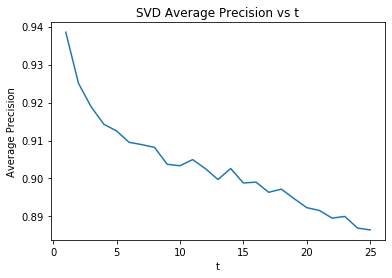

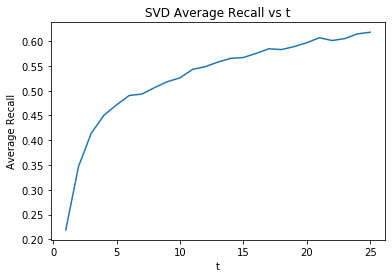

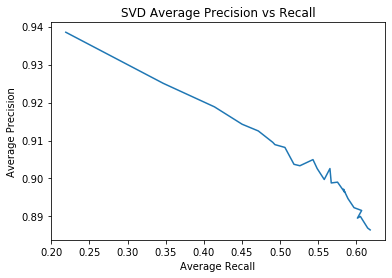

In [21]:
#question 38

nmf_biased_precision = []
nmf_biased_recall = []
kf = KFold(n_splits=10)

for t in ts:
    temp_prec = []
    temp_recall = []

    for trainset, testset in kf.split(data):
        nmf = SVD(n_factors=28, biased=True)
        nmf.fit(trainset)
        trimmed_testset = testset_trim(testset, t)
        pred = nmf.test(trimmed_testset)
    
        precisions, recalls = precision_recall(pred, t)
        fold_mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        fold_mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
            
        temp_prec.append(fold_mean_prec)
        temp_recall.append(fold_mean_recall)
    
    t_mean_prec = sum(prec for prec in temp_prec) / len(temp_prec)
    t_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    nmf_biased_precision.append(t_mean_prec)
    nmf_biased_recall.append(t_mean_recall)
    
    
plt.plot(ts, nmf_biased_precision)
plt.title("SVD Average Precision vs t")
plt.xlabel('t')
plt.ylabel('Average Precision')
plt.show()

plt.plot(ts, nmf_biased_recall)
plt.title("SVD Average Recall vs t")
plt.xlabel('t')
plt.ylabel('Average Recall')
plt.show()

plt.plot(nmf_biased_recall, nmf_biased_precision)
plt.title("SVD Average Precision vs Recall")
plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.show()


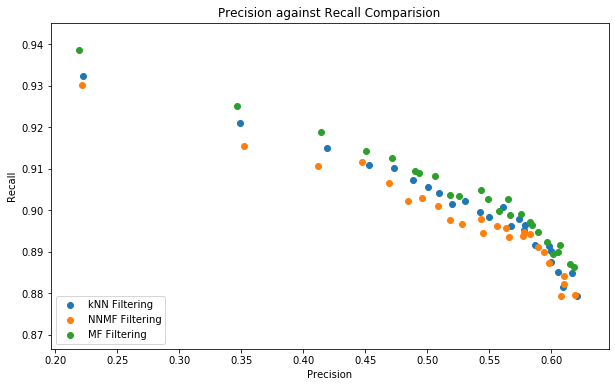

In [22]:
#question 39

#plt.gcf().clear()
plt.figure(figsize=(10,6))
plt.scatter(knn_recall,knn_precision, label='kNN Filtering')
plt.scatter(nmf_recall,nmf_precision, label='NNMF Filtering')
plt.scatter(nmf_biased_recall,nmf_biased_precision, label='MF Filtering')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision against Recall Comparision')
plt.legend(loc="lower left")
plt.show()

In [ ]:
#save?